# Using a random forest for demographic model selection
In Schrider and Kern (2017) we give a toy example of demographic model selection via supervised machine learning in Figure Box 1. Following a discussion on twitter, Vince Buffalo had the great idea of our providing a simple example of supervised ML in population genetics using a jupyter notebook; this notebook aims to serve that purpose by showing you exactly how we produced that figure in our paper

## Preliminaries
The road map here will be to 1) do some simulation of three demographic models, 2) to train a classifier to distinguish among those models, 3) test that classifier with new simulation data, and 4) to graphically present how well our trained classifier works. 

To do this we will use coalescent simulations as implemented in Dick Hudson's well known `ms` software and for the ML side of things we will use the `scikit-learn` package. Let's start by installing these dependencies (if you don't have them installed already)

### Install, and compile `ms`
We have put a copy of the `ms` tarball in this repo, so the following should work upon cloning

In [1]:
#untar and compile ms and sample_stats
!tar zxf ms.tar.gz; cd msdir; gcc -o ms ms.c streec.c rand1.c -lm; gcc -o sample_stats sample_stats.c tajd.c -lm
#I get three compiler warnings from ms, but everything should be fine
#now I'll just move the programs into the current working dir
!mv msdir/ms . ; mv msdir/sample_stats .;

### Install `scikit-learn`
If you use anaconda, you may already have these modules installed, but if not you can install with either of the following

In [ ]:
!conda install scikit-learn --yes

or if you don't use `conda`, you can use `pip` to install scikit-learn with

In [ ]:
!pip install -U scikit-learn

# Step 1: create a training set and a testing set
We will create a training set using simulations from three different demographic models: equilibrium population size, instantaneous population growth, and instantaneous population contraction. As you'll see this is really just a toy example because we will perform classification based on data from a single locus; in practice this would be ill-advised and you would want to use data from many loci simulataneously. 

So lets do some simulation using `ms` and summarize those simulations using the `sample_stats` program that Hudson provides. Ultimately we will only use two summary stats for classification, but one could use many more. Each of these simulations should take a few seconds to run.

In [2]:
#simulate under the equilibrium model
!./ms 20 2000 -t 100 -r 100 10000 | ./sample_stats > equilibrium.msOut.stats

In [3]:
#simulate under the contraction model
!./ms 20 2000 -t 100 -r 100 10000 -en 0 1 0.5 -en 0.2 1 1 | ./sample_stats > contraction.msOut.stats

In [4]:
#simulate under the growth model
!./ms 20 2000 -t 100 -r 100 10000 -en 0.2 1 0.5 | ./sample_stats > growth.msOut.stats

In [8]:
#now lets suck up the data columns we want for each of these files, and create one big training set; we will use numpy for this
# note that we are only using two columns of the data- these correspond to segSites and Fay & Wu's H
import numpy as np
X1 = np.loadtxt("equilibrium.msOut.stats",usecols=(3,9))
X2 = np.loadtxt("contraction.msOut.stats",usecols=(3,9))
X3 = np.loadtxt("growth.msOut.stats",usecols=(3,9))
X = np.concatenate((X1,X2,X3))

#create associated 'labels' -- these will be the targets for training
y = [0]*len(X1) + [1]*len(X2) + [2]*len(X3)
Y = np.array(y)


In [9]:
#the last step in this process will be to shuffle the data, and then split it into a training set and a testing set
#the testing set will NOT be used during training, and will allow us to check how well the classifier is doing
#scikit-learn has a very convenient function for doing this shuffle and split operation
#
# will will keep out 10% of the data for testing

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1)

# Step 2: train our classifier and visualize decision surface
Now that we have a training and testing set ready to go, we can move on to training our classifier. For this example we will use a random forest classifier (Breiman 2001). This is all implemented in `scikit-learn` and so the code is very brief. 

In [10]:
from sklearn.ensemble import RandomForestClassifier

rfClf = RandomForestClassifier(n_estimators=100,n_jobs=10)
clf = rfClf.fit(X_train, Y_train)


That's it! The classifier is trained. This Random Forest classifer used 100 decision trees in its ensemble, a pretty large number considering that we are only using two summary stats to represent our data. Nevertheless it trains on the data very, very quickly.

Confession: the real reason we are using only two summary statistics right here is because it makes it really easy to visualize that classifier's decision surface: which regions of the feature space would be assigned to which class? Let's have a look!

(Note: I have increased the h argument for the call to `make_meshgrid` below, coarsening the contour plot in the interest of efficiency. Decreasing this will yield a smoother plot, but may take a while and use up a lot more memory. Adjust at your own risk!)

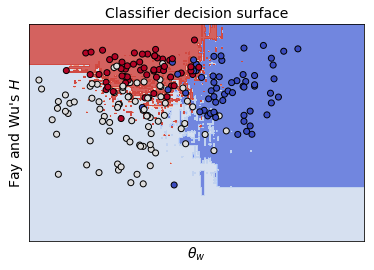

In [17]:
from sklearn.preprocessing import normalize

#These two functions (taken from scikit-learn.org) plot the decision boundaries for a classifier.
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_meshgrid(x, y, h=.05):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

#Let's do the plotting
import matplotlib.pyplot as plt
fig,ax= plt.subplots(1,1)
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1, h=0.2)
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
# plotting only a subset of our data to keep things from getting too cluttered
ax.scatter(X_test[:200, 0], X_test[:200, 1], c=Y_test[:200], cmap=plt.cm.coolwarm, edgecolors='k')
ax.set_xlabel(r"$\theta_{w}$", fontsize=14)
ax.set_ylabel(r"Fay and Wu's $H$", fontsize=14)
ax.set_xticks(())
ax.set_yticks(())
ax.set_title("Classifier decision surface", fontsize=14)
plt.show()

Above we can see which regions of our feature space are assigned to each class: dark blue shaded areas will be classified as Equilibrium, faint blue as Contraction, and red as Growth. Note the non-linear decision surface. Looks pretty cool! And also illustrates how this type of classifier might be useful for discriminating among classes that are difficult to linearly separate. Also plotted are a subset of our test examples, as dots colored according to their true class. Looks like we are doing pretty well but have a few misclassifications. Would be nice to quantify this somehow, which brings us to...

# Step 3: benchmark our classifier
The last step of the process is to use our trained classifier to predict which demographic models our test data are drawn from. Recall that the classifier hasn't seen these test data so this should be a fair test of how well the classifier will perform on any new data we throw at it in the future. We will visualize performance using a confusion matrix. 

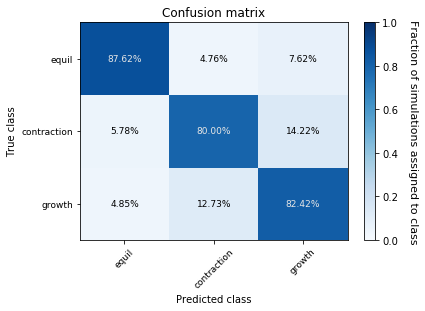

In [19]:
#here's the confusion matrix function
def makeConfusionMatrixHeatmap(data, title, trueClassOrderLs, predictedClassOrderLs, ax):
    data = np.array(data)
    data = normalize(data, axis=1, norm='l1')
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues, vmin=0.0, vmax=1.0)

    for i in range(len(predictedClassOrderLs)):
        for j in reversed(range(len(trueClassOrderLs))):
            val = 100*data[j, i]
            if val > 50:
                c = '0.9'
            else:
                c = 'black'
            ax.text(i + 0.5, j + 0.5, '%.2f%%' % val, horizontalalignment='center', verticalalignment='center', color=c, fontsize=9)

    cbar = plt.colorbar(heatmap, cmap=plt.cm.Blues, ax=ax)
    cbar.set_label("Fraction of simulations assigned to class", rotation=270, labelpad=20, fontsize=11)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.axis('tight')
    ax.set_title(title)

    #labels
    ax.set_xticklabels(predictedClassOrderLs, minor=False, fontsize=9, rotation=45)
    ax.set_yticklabels(reversed(trueClassOrderLs), minor=False, fontsize=9)
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    
#now the actual work
#first get the predictions
preds=clf.predict(X_test)

counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(Y_test)):
    counts[Y_test[i]][preds[i]] += 1
counts.reverse()
classOrderLs=['equil','contraction','growth']

#now do the plotting
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

Looks pretty good. But can we make it better? Well a simple way might be to increase the number of features (i.e. summary statistics) we use as input. Let's give that a whirl using all of the output from Hudson's `sample_stats`

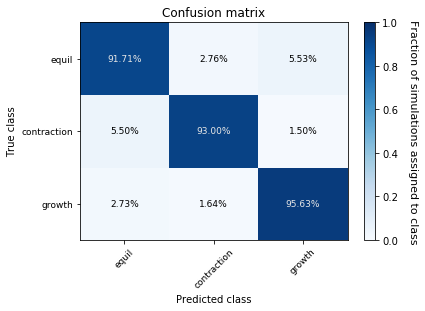

In [20]:
X1 = np.loadtxt("equilibrium.msOut.stats",usecols=(1,3,5,7,9))
X2 = np.loadtxt("contraction.msOut.stats",usecols=(1,3,5,7,9))
X3 = np.loadtxt("growth.msOut.stats",usecols=(1,3,5,7,9))
X = np.concatenate((X1,X2,X3))
#create associated 'labels' -- these will be the targets for training
y = [0]*len(X1) + [1]*len(X2) + [2]*len(X3)
Y = np.array(y)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.1)
rfClf = RandomForestClassifier(n_estimators=100,n_jobs=10)
clf = rfClf.fit(X_train, Y_train)
preds=clf.predict(X_test)
counts=[[0.,0.,0.],[0.,0.,0.],[0.,0.,0.]]
for i in range(len(Y_test)):
    counts[Y_test[i]][preds[i]] += 1
counts.reverse()
fig,ax= plt.subplots(1,1)
makeConfusionMatrixHeatmap(counts, "Confusion matrix", classOrderLs, classOrderLs, ax)
plt.show()

Even better!

Hopefully this simple example gives you the gist of how supervised ML can be used. In the future we will populate this GitHub repository with further examples that might be illustrative. 